Generate FEM solution for 2D Poisson problem

* The mesh configuration is fixed to be square given image as input
* Apply both Dirichlet and Neumann boundary conditions for irregular geometry distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from PIL import Image
from fea.fea2d_mesh import SquareMeshThermal
from fea.fea2d_thermal import ThermalFEM
from fea.project_input import project_input
from fea.boundary import define_boundary_nodes

#### Import the image

In [2]:
datafile = "data_Ti64/thermal_Ti64.h5"
samples = ['G5v', 'G6a', 'Y6v', 'Y6a']
im = Image.open('data_Ti64/'+samples[0]+'_XZ_256.tif')
imarray = np.array(im)/255

In [3]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img)
    plt.axis('off')
    plt.colorbar(im1)

#plot_image(imarray) # note this is the element distribution

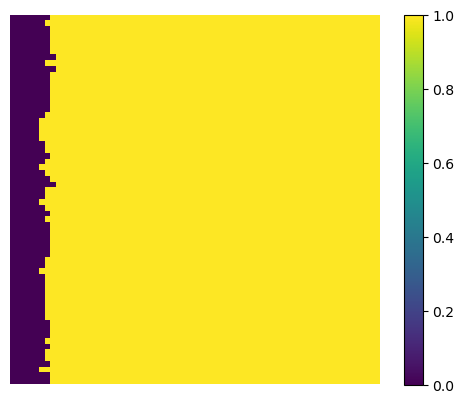

In [4]:
# reduce the size of the image
times = 4
imarray = imarray[::times, ::times]
plot_image(imarray) # note this is the element distribution

#### Define the loading types

In [5]:
def loading_type1(node_mask, bc):
    '''
    boundary node list: [top, bottom, left, right, curved]

    Loading (0 is x, 1 is y direction): 
    Fix the top boundary, apply random loading at bottom boundary
    '''

    h, w = node_mask.shape
    top_idx = np.where(bc[0][0] == 1)
    bottom_idx = np.where(bc[1][0] == 1)
    left_idx = np.where(bc[2][0] == 1)
    right_idx = np.where(bc[3][0] == 1)
    curved_idx = np.where(bc[4][0] == 1)

    # define dirich boundary (use for FEA and FEA-Net)
    # set top temperature to be 0, bottom to be 2, right to be 1
    dirich_idx = np.zeros((h, w), dtype=np.int32)
    # dirich_idx[top_idx[0], top_idx[1]] = 1 # fix at top
    # dirich_idx[bottom_idx[0], bottom_idx[1]] = 1 # fix at bottom
    dirich_idx[right_idx[0], right_idx[1]] = 1 # fix at right
    dirich_value = np.zeros_like(dirich_idx)
    # dirich_value[top_idx[0],top_idx[1]] = 0 
    # dirich_value[bottom_idx[0], bottom_idx[1]] = 2
    dirich_value[right_idx[0], right_idx[1]] = 1

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask

    # define neumann boundary, 1.0 neumann boundary; 0 else
    # set left flux to be 2
    traction_idx = np.zeros((h, w), dtype=np.int32)
    traction_value = np.zeros_like(traction_idx)
    traction_idx[curved_idx[0], curved_idx[1]] = 1 
    traction_value[curved_idx[0], curved_idx[1]] = 2 

    return dirich_idx, dirich_idx_feanet, dirich_value, traction_idx, traction_value

#### Define the problem

In [6]:
hsize = 0.0061*times # mm
elem_mask = np.copy(imarray)
h, w = elem_mask.shape
material = np.ones((h, w, 1))
material[:,:,0] *= 1 # alpha, thermal coefficient
node_mask = project_input(elem_mask)

# define boundary nodes and connections
bc = define_boundary_nodes(elem_mask) # top, bottom, left, right, curved
neumann_connlist = [bc[4][1]] # curved boundary is neumann
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, bc)
f_val = np.zeros_like(dirich_val)


In [7]:
# generate a mesh grid
mesh = SquareMeshThermal(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [8]:
# generate FEM problem
problem = ThermalFEM(mesh, material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))

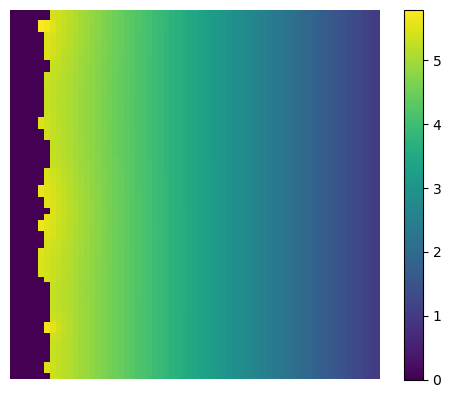

In [9]:
problem.Solve()
problem.PlotField()

#### Post-processing

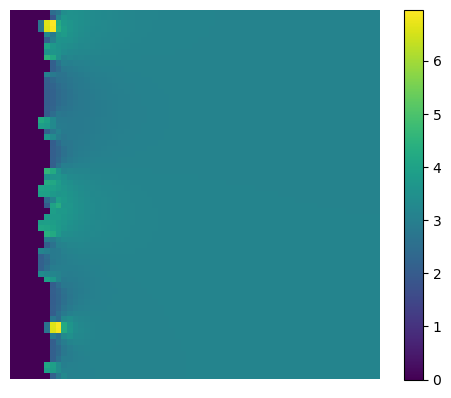

In [11]:
H = problem.ComputeHeatFlux()
problem.PlotField(problem.flux[:,0])

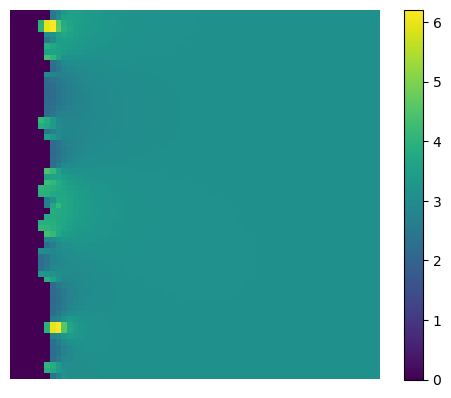

In [12]:
problem.ComputeAverageHeatFlux()
problem.PlotField(problem.flux_avg[:,0])

In [13]:
problem.flux_avg[:,0].reshape(65,65)[20:35,5:10]

array([[2.240822 , 2.4328856, 2.7424097, 2.9076123, 2.9799001],
       [2.2522347, 2.483149 , 2.7867615, 2.9060197, 2.9897397],
       [3.0986989, 2.9869158, 2.888275 , 2.9188786, 3.0345604],
       [0.       , 2.3085368, 2.61852  , 3.003146 , 3.124075 ],
       [0.       , 2.9615886, 2.9891567, 3.1556067, 3.3029182],
       [0.       , 4.3435173, 4.133709 , 3.776384 , 3.4801197],
       [4.0989823, 4.0425043, 3.9476254, 3.7880414, 3.6184318],
       [3.9010165, 3.9014463, 3.8621464, 3.7702284, 3.6632428],
       [0.       , 3.8246052, 3.8131404, 3.7733061, 3.6930256],
       [0.       , 0.       , 3.8488772, 3.8062484, 3.7306743],
       [0.       , 2.6703663, 3.7254467, 4.151962 , 3.7635937],
       [0.       , 2.6733758, 3.1498904, 3.724489 , 3.7459857],
       [3.9466288, 3.90258  , 3.7670722, 3.6730826, 3.6617382],
       [4.05337  , 3.9998105, 3.915693 , 3.7800875, 3.6396844],
       [0.       , 4.275705 , 4.1131372, 3.8448415, 3.5848482]],
      dtype=float32)

#### Create dataset

In [14]:
def conn_list2array(node_mask, conn_list):
    '''Convert a connection list into nparrays '''
    h, w = node_mask.shape
    conn_array = np.zeros((h,w,len(conn_list)))
    print(len(conn_list))
    for i in range(len(conn_list)):
        conn_len = conn_list[i].shape[0]
        subarray = np.full((h*w),-1) 
        subarray[:conn_len] = conn_list[i][:,0]
        subarray[conn_len] = conn_list[i][-1,1]
        conn_array[:,:,i] = subarray.reshape((h,w))
    return conn_array


In [15]:
# Create dataset, please note that all neumann connection should be the same
n_data = 1

dataset = {}
dirich_idx_data = np.zeros((n_data, h+1, w+1, 1))
dirich_value_data = np.zeros((n_data, h+1, w+1, 1))
neumann_idx_data = np.zeros((n_data, h+1, w+1, 1))
neumann_conn_data = np.zeros((n_data, h+1, w+1, len(neumann_connlist)))
neumann_value_data = np.zeros((n_data, h+1, w+1, 1))
mask_data = np.zeros((n_data, h+1, w+1, 1))
material_data = np.zeros((n_data, h, w, 1))
f_data = np.zeros((n_data, h+1, w+1, 1))
u_data = np.zeros((n_data, h+1, w+1, 1))
for i in range(n_data):
    dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, bc)
    problem = ThermalFEM(mesh, material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))    
    problem.Solve()
    material_data[i] = material*elem_mask.reshape((h,w,1))
    dirich_idx_data[i,:,:,0] = dirich_idx_feanet
    dirich_value_data[i,:,:,0] = dirich_val
    neumann_idx_data[i,:,:,0] = neumann_idx
    neumann_value_data[i,:,:,0] = neumann_val
    neumann_conn_data[i] = conn_list2array(node_mask, neumann_connlist)
    f_data[i,:,:,0] = f_val
    u_data[i,:,:,0] = problem.d.reshape((h+1, w+1))
    print("Problem #-"+str(i)+" solved")

    # create mask images
    temp = np.zeros(((h+1)*(w+1),))
    temp[mesh.valid_node] = 1
    mask_data[i,:,:,0] = temp.reshape((h+1,w+1))

1
Problem #-0 solved


In [16]:
dataset['mask'] = mask_data
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['neumann_value'] = neumann_value_data
dataset['neumann_conn'] = neumann_conn_data
dataset['material'] = material_data
dataset['source'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item